Рубаненко Евгений  
ФИВТ 595  
Вторая практическая работа

# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import tqdm

from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [142]:
digits = load_digits()

In [143]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

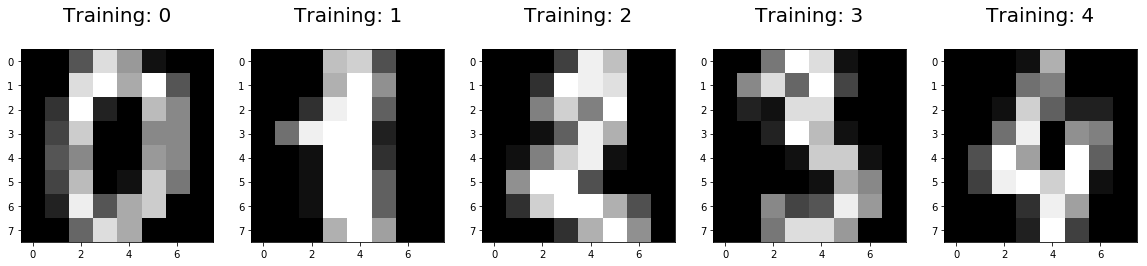

In [144]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize=20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

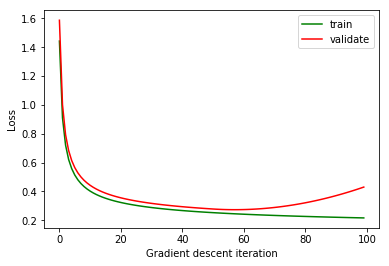

In [5]:
plt.plot([1 / math.log(i + 2) for i in range(100)],
         color='green', label='train')
plt.plot([1 / math.log(i + 2) * 1.1 +\
          ((i / 50.0 - 1) ** 2. / 5. if i > 50 else 0.) for i in range(100)],
         color='red', label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [6]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros((len(y), n_classes), dtype=np.uint8)
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split((digits.data - 8) / 16,
                                                    one_hot(digits.target, 10),
                                                    test_size=0.33,
                                                    random_state=0)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки мы хотим найти вектор $(p_0,\ldots,p_{10})$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где x - наш вектор картинки, а результат - числовой вектор размерности 10 с какими-то числами. Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy 

Кросс-энтропия считается следующим образом:  
$$L(y, pred) = -\cfrac{1}{N}\sum_{n=1}^{N}y_{n} log(pred_{n})$$

In [7]:
def softmax(W, b, x):
    tmp = np.exp(np.dot(x, W.T) + b)
    return (tmp.T / tmp.sum(axis=1)).T

# Кросс-энтропия предсказанного вектора pred и данного вектора y
def loss(y, pred):
    return -np.mean(np.sum(y * np.log(pred), axis=-1))

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

Посчитаем градиент функции $loss$ в точке (x, y).  
* Будем хранить две матрицы: для производных по $W_{kj}$ и по $b_{i}$
* Производная по $W_{kj}$:
$$\cfrac{dL(y,p)}{dW_{kj}} = \cfrac{d(-\sum_{i=1}^{10}y_{i}log(p_{i}))}{dW_{kj}} =$$
$$= \cfrac{d(-\sum_{i=1, i\ne k}^{10}y_{i}log(p_{i}))}{dW_{kj}} - \cfrac{d(y_{k}log(p_{k}))}{dW_{kj}} =$$
Учтем, что $log(p_{i}) = (\sum_{l=1}^{64}W_{il}x_{l} + b_{i}) - log(\sum_{m=1}^{10}e^{(\sum_{l=1}^{64}W_{ml}x_{l} + b_{m})})$. Тогда
$$=p_{k}x_{j}\sum_{i=1,i\ne k}^{10}y_{i} - y_{k}x_{j} + p_{k}x_{j}y_{k} = (p_{k} - y_{k})x_{j}$$
* Производная по $b_{k}$:
$$\cfrac{dL(y,p)}{db_{k}} = \cfrac{d(-\sum_{i=1}^{10}y_{i}log(p_{i}))}{db_{k}} =$$
$$= \cfrac{d(-\sum_{i=1, i\ne k}^{10}y_{i}log(p_{i}))}{db_{k}} - \cfrac{d(y_{k}log(p_{k}))}{db_{k}} = p_{k} - y_{k}$$

In [8]:
# Градиент в заданной точке
def compute_gradients(out, y, x):
    y = y.reshape(-1,1)
    out = out.reshape(-1,1)
    x = x.reshape(1,-1)
    return np.hstack((np.dot(out - y, x), (out - y)))

# Усредняем по всем точкам
def gradients(W, b, x, y):
    sm = softmax(W, b, x)        
    e = [compute_gradients(a, c, b) for a, c, b in zip(sm, y, x)]                         
    return np.mean(e, axis=0)   

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [9]:
# Градиентный спуск с фиксированным шагом

eta = 1

# Начальные параметры
W = np.zeros((10, 64))
b = np.zeros(10)

# Потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

# Градиентный спуск
for i in tqdm.tqdm(range(5000)):
    grad = gradients(W, b, x_train, y_train)
    gradW = grad.T[:-1].T 
    gradb = grad.T[-1].T
    W = W - eta * gradW
    b = b - eta * gradb
    losses_train.append(loss(y_train, softmax(W, b, x_train)))
    losses_valid.append(loss(y_test, softmax(W, b, x_test)))

100%|██████████| 5000/5000 [01:43<00:00, 48.42it/s]


# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

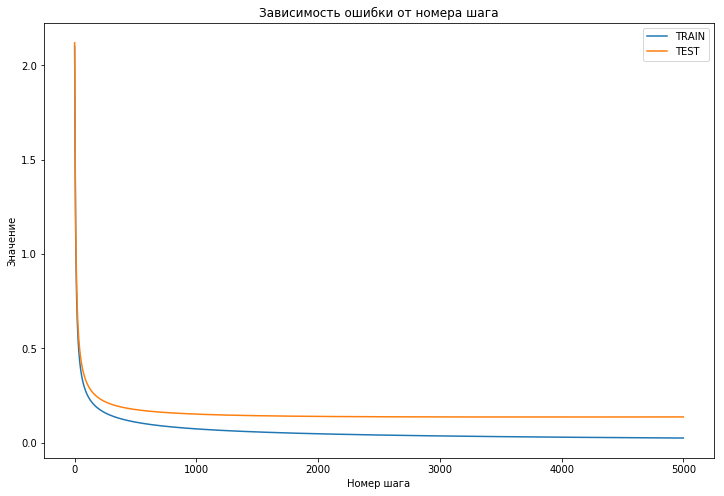

In [11]:
plt.figure(figsize=(12,8))
plt.plot(losses_train, label='TRAIN')
plt.plot(losses_valid, label='TEST')
plt.legend()
plt.xlabel('Номер шага')
plt.ylabel('Значение')
plt.title('Зависимость ошибки от номера шага')
plt.show()

In [12]:
print('Шаг, на котором был достигнут минимум ошибки для обучающей выборки',
      np.argmin(losses_train))
print('Шаг, на котором был достигнут минимум ошибки для тестовой выборки',
      np.argmin(losses_valid))

Шаг, на котором был достигнут минимум ошибки для обучающей выборки 4999
Шаг, на котором был достигнут минимум ошибки для тестовой выборки 3839


Заметим, что после 3839 шага модель начинает переобучаться - увеличивается значение функции потерь.

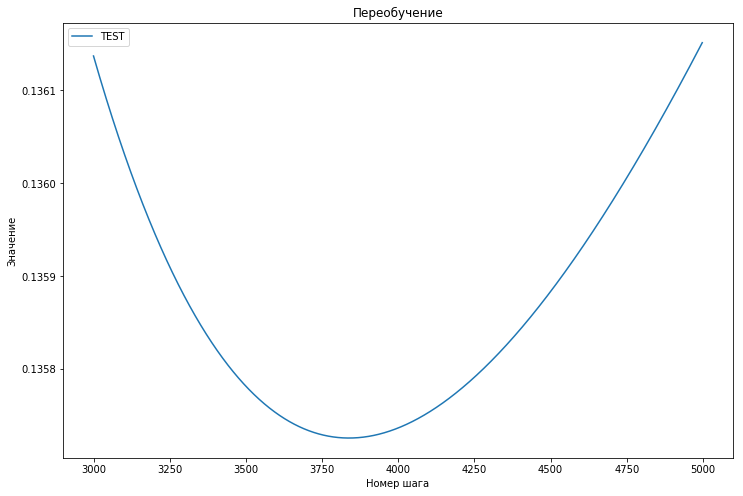

In [16]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(2999, 4999), losses_valid[-2000:], label='TEST')

plt.xlabel('Номер шага')
plt.ylabel('Значение')
plt.legend()
plt.title('Переобучение')
plt.show()

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

Выбор шага методом Армихо происходит по следующиму принципу:  
* На каждой итерации проверяется условие
$$f(x + \Delta x) > f(x) + \alpha s \nabla f(x)^{T}\Delta x$$
* Если оно выполнено, то для шаг изменяется по правилу
$$s = \beta s$$

В нашем случае минимизируется функция $loss$, а скалярное произведение в конце условия есть просто сумма квадратов всех элементов матрицы градиента.

In [17]:
def armijo (W, b, x, y, alpha=0.5, beta=0.5):
    s = 100
    grad = gradients(W, b, x, y)
    gradW = grad.T[:-1].T
    gradb = grad.T[-1].T
    while (loss(y, softmax(W - s * gradW, b - s * gradb, x)) >=\
           loss(y, softmax(W, b, x)) - beta * s * np.sum(grad * grad)):
        s *= alpha
    return s

In [25]:
# Градиентный спуск с выбором шага по правилу Армихо

# Начальные параметры
W = np.zeros((10, 64))
b = np.zeros(10)

# Потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

# Градиентный спуск
for i in tqdm.tqdm(range(1000)):
    grad = gradients(W, b, x_train, y_train)
    gradW = grad.T[:-1].T 
    gradb = grad.T[-1].T
    eta = armijo(W, b, x_train, y_train)
    W = W - eta * gradW
    b = b - eta * gradb
    losses_train.append(loss(y_train, softmax(W, b, x_train)))
    losses_valid.append(loss(y_test, softmax(W, b, x_test)))

100%|██████████| 1000/1000 [00:43<00:00, 23.14it/s]


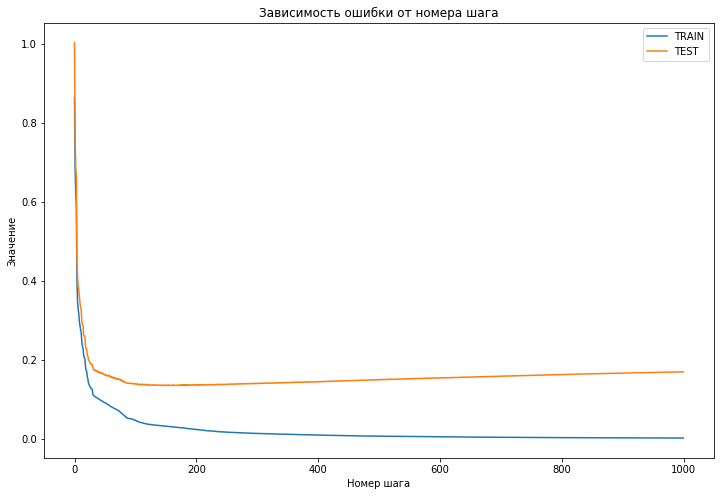

In [26]:
plt.figure(figsize=(12,8))
plt.plot(losses_train, label='TRAIN')
plt.plot(losses_valid, label='TEST')
plt.legend()
plt.xlabel('Номер шага')
plt.ylabel('Значение')
plt.title('Зависимость ошибки от номера шага')
plt.show()

In [27]:
print('Шаг, на котором был достигнут минимум ошибки для обучающей выборки',
      np.argmin(losses_train))
print('Шаг, на котором был достигнут минимум ошибки для тестовой выборки',
      np.argmin(losses_valid))

Шаг, на котором был достигнут минимум ошибки для обучающей выборки 999
Шаг, на котором был достигнут минимум ошибки для тестовой выборки 159


Заметим, что после 159 шага модель начинает переобучаться - увеличивается значение функции потерь.

Проверим, что сходится быстрее: градиентный спуск с фиксированным шагом 100, или с выбором шага по правилу Армихо.

In [33]:
# Градиентный спуск с фиксированным шагом

eta = 100

# Начальные параметры
W = np.zeros((10, 64))
b = np.zeros(10)

# Потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

# Градиентный спуск
for i in tqdm.tqdm(range(5000)):
    grad = gradients(W, b, x_train, y_train)
    gradW = grad.T[:-1].T 
    gradb = grad.T[-1].T
    W = W - eta * gradW
    b = b - eta * gradb
    losses_train.append(loss(y_train, softmax(W, b, x_train)))
    losses_valid.append(loss(y_test, softmax(W, b, x_test)))

100%|██████████| 5000/5000 [01:39<00:00, 50.26it/s]


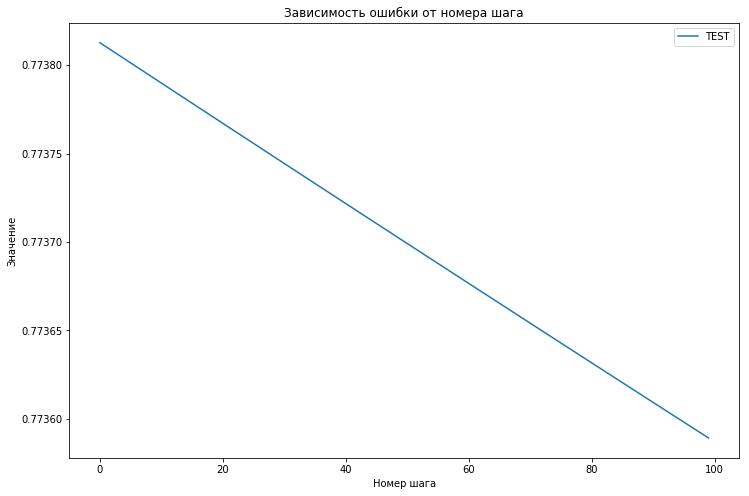

In [42]:
plt.figure(figsize=(12,8))
plt.plot(losses_valid[4900:], label='TEST')
plt.legend()
plt.xlabel('Номер шага')
plt.ylabel('Значение')
plt.title('Зависимость ошибки от номера шага')
plt.show()

Видим, что даже за 5000 итераций градиентный спуск с фиксированным шагом 100 не достигает своего минимума (отметим, что на 5000 итерации ошибка данного подхода больше, чем ошибка при использовании метода Армихо).

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

Еще раз обучим модель (теперь обучение будем проводить точно до минимума ошибки), а затем узнаем, как часто мы ошибаемся на тестовой выборке.

In [145]:
# Градиентный спуск с фиксированным шагом

eta = 1

# Начальные параметры
W = np.zeros((10, 64))
b = np.zeros(10)

# Потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

# Градиентный спуск
for i in tqdm.tqdm(range(3840)):
    grad = gradients(W, b, x_train, y_train)
    gradW = grad.T[:-1].T 
    gradb = grad.T[-1].T
    W = W - eta * gradW
    b = b - eta * gradb
    losses_train.append(loss(y_train, softmax(W, b, x_train)))
    losses_valid.append(loss(y_test, softmax(W, b, x_test)))

100%|██████████| 3840/3840 [01:15<00:00, 50.90it/s]


In [147]:
test = softmax(W, b, x_test)

score = 0
correct_index = []
incorrect_index = []
correct_values = []
incorrect_values = []
incorrect_real = []

for i in range(len(test)):
    k = np.argmax(test[i])
    m = np.argmax(y_test[i])
    if k == m:
        score += 1
        correct_values.append(k)
        correct_index.append(i + len(x_train))
    else:
        incorrect_values.append(k)
        incorrect_real.append(m)
        incorrect_index.append(i + len(x_train))
        
score /= len(test)

In [148]:
print('Точность прогнозов', round(score, 4))

Точность прогнозов 0.9562


Пример картинок, на которых происходит неправильное распознавание.

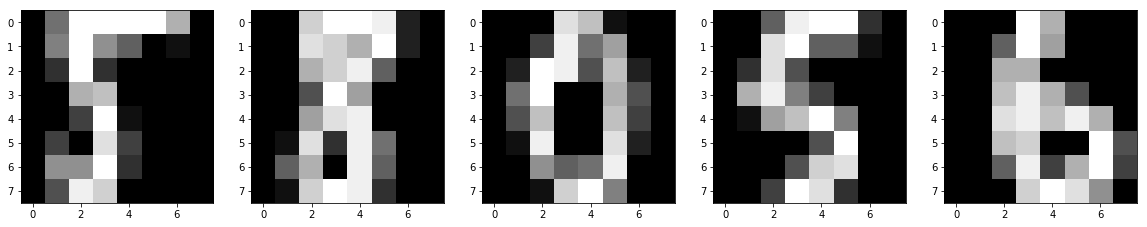

In [149]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[incorrect_index[:5]],
                                           digits.target[incorrect_index[:5]])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)

In [127]:
print('Предсказанные', incorrect_values[:5])
print('Реальные', incorrect_real[:5])

Предсказанные [9, 1, 4, 4, 1]
Реальные [5, 2, 7, 7, 6]


Пример картинок, на которых распознавание произошло корректно.

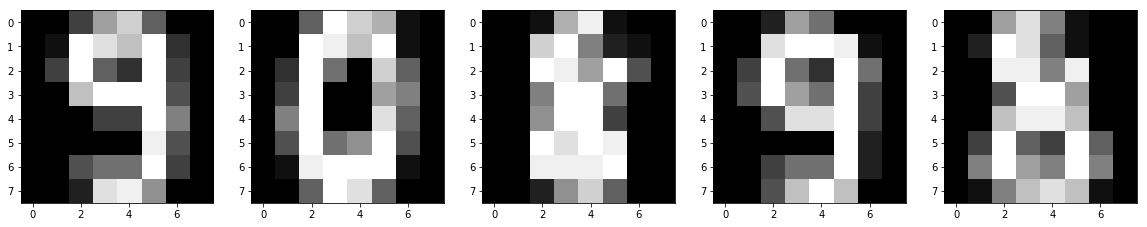

In [153]:
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(digits.data[correct_index[-5:]],
                                           digits.target[correct_index[-5:]])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)

In [152]:
print('Предсказанные', correct_values[-5:])

Предсказанные [5, 2, 1, 1, 2]


In [154]:
# Дальше идут просто пустые ячейки, чтобы корректно в pdf конвертировать